In [1]:
import folium
import pickle
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from utils import linear_scaler

# Graph Analysis

Now that the graph is partially constructed, let's perform some analysis on it.

In [2]:
# Start by loading pickled data
G = pickle.load(open('data/processed/railgraph.pickle', 'rb'))
stop_id_to_name = pickle.load(open('data/processed/stop_id_to_name', 'rb'))
edges_counts = pd.read_pickle('data/processed/edges_counts.pickle', )
railway_stops = pd.read_pickle('data/processed/railway_stops.pickle')

In [3]:
G.remove_nodes_from(list(nx.isolates(G)))

## Centrality

### Betweenness centrality

In [4]:
# Compute betweenness centrality of graph
btwn_centrality = nx.betweenness_centrality(G, weight = 'trains_count')

# Take top 20, and average
btwn_centrality_20 = dict(sorted(btwn_centrality.items(), key=lambda item: - item[1])[:20]).keys()
avg_btwn_centrality = np.mean(list(btwn_centrality.values()))

print('The network\'s average betweenness centrality is {:.4f}.'.format(avg_btwn_centrality))
print('Top 20 stops with the highest betweenness centrality:')
for stop in btwn_centrality_20:
    print('{:.<20} {:.4f}'.format(stop_id_to_name[stop], btwn_centrality[stop]))

The network's average betweenness centrality is 0.0074.
Top 20 stops with the highest betweenness centrality:
Olten............... 0.4795
Brig................ 0.3930
Zürich HB........... 0.3384
Zollikofen.......... 0.2799
Basel SBB........... 0.2587
Münsingen........... 0.2486
Bellinzona.......... 0.2277
Nyon................ 0.1736
Sion................ 0.1692
Lausanne............ 0.1669
Bern................ 0.1612
Amriswil............ 0.1482
Sulgen.............. 0.1457
Weinfelden.......... 0.1444
Ostermundigen....... 0.1301
Romanshorn.......... 0.1282
Aigle............... 0.1226
St. Gallen.......... 0.1209
Montreux............ 0.1161
Flüelen............. 0.1133


We can see that the 20 most central nodes according to the betweenness centrality are mostly Swiss agglomerations. However, we see some less major cities with a somewhat important centrality: i.e. Visp, Landquart, Ins. These are probably smalles cities through which has to pass because of their geographic localisation: i.e. the stop might be on the intersection of multiple lines for example. 

### Closeness centrality

In [5]:
clsn_centrality = nx.closeness_centrality(G)

clsn_centrality_20 = dict(sorted(clsn_centrality.items(), key=lambda item: - item[1])[:20]).keys()
avg_clsn_centrality = np.mean(list(clsn_centrality.values()))

print('The network\'s average closeness centrality is {:.4f}.'.format(avg_clsn_centrality))
print('Top 20 stops with the highest closeness centrality:')
for stop in clsn_centrality_20:
    print('{:.<20} {:.4f}'.format(stop_id_to_name[stop], clsn_centrality[stop]))

The network's average closeness centrality is 0.0917.
Top 20 stops with the highest closeness centrality:
Olten............... 0.1629
Zürich HB........... 0.1621
Bern................ 0.1615
Basel SBB........... 0.1588
Münsingen........... 0.1511
Brig................ 0.1509
Aarau............... 0.1505
Oensingen........... 0.1489
Brugg AG............ 0.1489
Fribourg/Freiburg... 0.1479
Zürich Altstetten... 0.1476
Zollikofen.......... 0.1453
Solothurn........... 0.1453
Thun................ 0.1452
Luzern.............. 0.1443
Liestal............. 0.1440
Sargans............. 0.1437
Zofingen............ 0.1433
Burgdorf............ 0.1429
Zürich Flughafen.... 0.1429


### Degree centrality

In [6]:
degree_centrality = nx.degree_centrality(G)

degree_centrality_20 = dict(sorted(degree_centrality.items(), key=lambda item: - item[1])[:20]).keys()
avg_degree_centrality = np.mean(list(degree_centrality.values()))

print('The network\'s average degree centrality is {:.4f}.'.format(avg_degree_centrality))
print('Top 20 stops with the highest degree centrality:')
for stop in degree_centrality_20:
    print('{:.<20} {:.4f}'.format(stop_id_to_name[stop], degree_centrality[stop]))

The network's average degree centrality is 0.0018.
Top 20 stops with the highest degree centrality:
Zürich HB........... 0.0175
Bern................ 0.0169
Olten............... 0.0169
Luzern.............. 0.0139
Lausanne............ 0.0114
Arth-Goldau......... 0.0102
Basel SBB........... 0.0096
Winterthur.......... 0.0090
Biel/Bienne......... 0.0090
St. Gallen.......... 0.0090
Genève.............. 0.0084
Aarau............... 0.0084
Pfäffikon SZ........ 0.0084
Solothurn........... 0.0078
Montreux............ 0.0078
Zürich Oerlikon..... 0.0072
Thun................ 0.0072
Chur................ 0.0072
Brugg AG............ 0.0072
Lugano.............. 0.0072


In [7]:
nx.set_node_attributes(G, btwn_centrality, 'betweenness_centrality')
nx.set_node_attributes(G, clsn_centrality, 'closeness_centrality')
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

In [8]:
# Inspired from Cao et al. (2019): combining centralities to 
# categorize nodes by importance
combined_centralities = {}
btwn_min, btwn_max = min(btwn_centrality.values()), max(btwn_centrality.values())
clsn_min, clsn_max = min(clsn_centrality.values()), max(clsn_centrality.values())
degr_min, degr_max = min(degree_centrality.values()), max(degree_centrality.values())

for node in G.nodes:
    combined_centralities[node] = 0
    combined_centralities[node] += (1/3)*(btwn_centrality[node] - btwn_min)/(btwn_max-btwn_min)
    combined_centralities[node] += (1/3)*(clsn_centrality[node] - clsn_min)/(clsn_max-clsn_min)
    combined_centralities[node] += (1/3)*(degree_centrality[node] - degr_min)/(degr_max-degr_min)

In [9]:
from sklearn.preprocessing import KBinsDiscretizer

X = sorted(combined_centralities.values(), reverse=True)
X = np.array(X).reshape(-1, 1)

# Look for 4 levels of importance
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

node_categories = dict(zip(combined_centralities.keys(), est.fit_transform(X).reshape(-1)))
nx.set_node_attributes(G, node_categories, 'category')

## Basic statistics

In [8]:
print(f'There are {G.size()} edges and {len(G.nodes)} nodes in our graph.')
print('The density is {:.4f}.'.format(nx.density(G)))
print('The graph has {} connected components. The largest component has size {}.'.format(nx.number_connected_components(G), len(max(nx.connected_components(G), key = len))))

There are 2514 edges and 1661 nodes in our graph.
The density is 0.0018.
The graph has 11 connected components. The largest component has size 1558.


In [9]:
average_clustering_coeff = nx.average_clustering(G, weight='trains_count')
global_efficiency = nx.global_efficiency(G  )

degrees = pd.Series(dict(G.degree()).values())
min_degree, avg_degree, max_degree = (degrees.min(), degrees.mean(), degrees.max())

assortativity = nx.degree_assortativity_coefficient(G, weight = 'trains_count')

print('The average clustering coefficient is {:.4f}.'.format(average_clustering_coeff))
print('The global efficiency is {:.4f}.'.format(global_efficiency))
print('The min, average and max degrees are {}, {:.4f} and {} respectively.'.format(min_degree, avg_degree, max_degree))
print('The degree assortativity is {:.4f}.'.format(assortativity))

The average clustering coefficient is 0.0132.
The global efficiency is 0.1068.
The min, average and max degrees are 1, 3.0271 and 29 respectively.
The degree assortativity is 0.3166.


In [10]:
weighted_degrees = pd.Series(dict(G.degree(weight='trains_count')).values())
(weighted_degrees.min(), weighted_degrees.mean(), weighted_degrees.max())
sorted(G.degree(weight='trains_count'), key=lambda x: x[1], reverse=True)[0]

('8503000', 2931)

In [11]:
connected_components = list(nx.connected_components(G))
largest_cc = G.subgraph(max(connected_components))

avg_shortest_path_largest_cc = nx.average_shortest_path_length(largest_cc)
diameter_largest_cc = nx.diameter(largest_cc)

print('There are {} connected components in our network.'.format(len(connected_components)))
print('The diameter of the largest connected component is {}'.format(diameter_largest_cc))
print('The average shortest path length of the largest connected component is {:.4f}.'.format(avg_shortest_path_largest_cc))

There are 11 connected components in our network.
The diameter of the largest connected component is 36
The average shortest path length of the largest connected component is 10.3190.


## Degree distribution

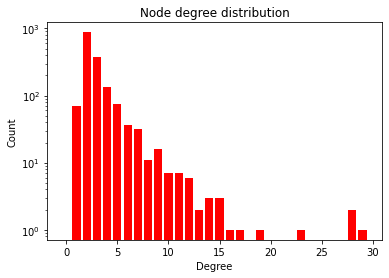

In [28]:
import matplotlib.pyplot as plt

hist = nx.degree_histogram(G)

plt.bar(range(len(hist)), hist, color = 'red')
plt.title('Node degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.yscale('log')
plt.savefig('./docs/degree_dist.png')
plt.show()

## Average nearest neighbor degree

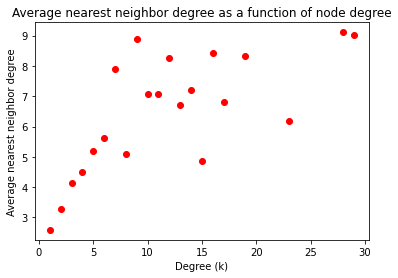

In [29]:
plt.scatter(x = nx.k_nearest_neighbors(G, weight = 'trains_count').keys(), y =nx.k_nearest_neighbors(G, weight = 'trains_count').values(), c = 'red')
plt.xlabel('Degree (k)')
plt.ylabel('Average nearest neighbor degree')
plt.title('Average nearest neighbor degree as a function of node degree')
plt.savefig('./docs/avg_nn_deg.png')
plt.show()

## Small world network

In [114]:
# Small world network analysis
sigma = nx.sigma(largest_cc, niter=1, nrand=10)
sigma

30.792948356693888

## Community detection

In [11]:
communities = nx.algorithms.community.greedy_modularity_communities(G)
communities = sorted(communities, reverse=True, key=len)

for i, comm in enumerate(communities):
    for node in comm:
        G.nodes[node]['community'] = i

cmap = plt.get_cmap('tab10')
cmap = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]

In [ ]:
m = folium.Map(location=[46.771413, 8.471689], zoom_start = 8, tiles='CartoDB Positron', min_zoom=8)

# Draw nodes
for node in G.nodes():
    lat, lon = G.nodes[node]['lat'], G.nodes[node]['lon']
    community = G.nodes[node]['community']
    folium.CircleMarker(
        location = (lat, lon),
        popup = '{}\nCommunity: {}'.format(G.nodes[node]['name'],  community+1),
        radius = 3 if community < 10 else 1,
        fill = True,
        color = cmap[community] if community < 10 else '#3388ff',
        fill_color = cmap[community] if community < 10 else '#3388ff',
        opacity = 1 if community < 10  else 0.3,
        fill_opacity = 0.3
    ).add_to(m)

m.save("network_communities.html")
m.save('docs/network_communities.html')
m

## City classification

In [15]:
node_category_sizes = {0: 1, 1:1, 2:3, 3:5}
node_category_colors = {0: '#444444', 1:'#2C8C99', 2:'#F7D08A', 3:'#C60018'}
node_category_opacities = {0: 0.5, 1: 0.5, 2:0.8, 3:1}
node_category_names = {0: 'Ultraperipheral', 1: 'Peripherial', 2:'Bridge', 3:'Core'}

In [ ]:
m = folium.Map(location=[46.771413, 8.471689], zoom_start = 8, tiles='CartoDB Positron', min_zoom=8)

# Draw nodes
for node, data in sorted(G.nodes(data=True), key=lambda x: x[1]['category']):
    lat, lon = data['lat'], data['lon']
    cat = data['category']
    folium.CircleMarker(
        location = [lat, lon],
        popup = '{}\n({} city)'.format(data['name'], node_category_names[cat]),
        radius = node_category_sizes[cat],
        fill = True,
        color = node_category_colors[cat],
        fill_color = node_category_colors[cat],
        opacity = node_category_opacities[cat],
        fill_opacity = node_category_opacities[cat]
    ).add_to(m)

m.save("network_nodes_classification.html")
m.save("docs/network_nodes_classification.html")
m